## Auswertung Zisterne Datenfiles
Datenfiles aus Zisternen-Controller auswerten

Remarks:<br>
11.05.19 Filterreinigung<br>
21.05.19 Anpassung Filterüberlauf von 203cm auf 183cm

### Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from sklearn import preprocessing
import os
import requests
from IPython.display import IFrame
import datetime
import re
from sklearn import tree

### Daten einlesen

In [2]:
# Datensammlung einlesen
df1=pd.read_csv('Datensammlung.csv',engine='python',sep=';',decimal=',',index_col=False)
df1['Timestamp']=pd.to_datetime(df1['Date'],format='%d.%m.%Y %H:%M')
#Umbenennung falsche Spaltennamen
df1=df1.rename(columns={"Measured quantity change 24h [Liter]": "Measured quantity change 1h [Liter]", "Calculated quantity change 24h [Liter]": "Calculated quantity change 1h [Liter]", "Refill quantity 24h [Liter]":"Refill quantity 1h [Liter]"})
df1.tail()

,Log File,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 1h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Usage in last 24h [Liter],Usage average in last 10d [Liter],Timestamp
629,181203_V310_4.csv,03.12.2018 16:17,1097,3446,98,Kein Fehler erkannt,1.51,180,14.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-03 16:17:00
630,181203_V310_4.csv,03.12.2018 17:17,1136,3568,100,Kein Fehler erkannt,0.00,180,16.23,0.0,122.0,156.0,21.0,Verstopft,NaN,NaN,2018-12-03 17:17:00
631,181203_V310_4.csv,03.12.2018 18:17,1221,3835,98,Kein Fehler erkannt,1.81,180,18.00,0.0,267.0,157.0,0.0,OK,NaN,NaN,2018-12-03 18:17:00
632,181203_V310_4.csv,03.12.2018 19:17,1330,4178,100,Kein Fehler erkannt,0.00,180,20.65,0.0,343.0,244.0,0.0,OK,NaN,NaN,2018-12-03 19:17:00
633,181203_V310_4.csv,03.12.2018 20:17,1437,4514,100,Kein Fehler erkannt,0.00,180,22.72,0.0,336.0,186.0,0.0,OK,NaN,NaN,2018-12-03 20:17:00


### Weitere Daten lesen ab 3.12.18
Alle Daten befinden sich im unterverzeichnis ./csv. Die obigen Daten stehen im ./bak verzeichnis

In [3]:
# Aktuelle Web-Page darstellen 
IFrame(src='http://192.168.178.5', width=700, height=800)

Erst mal neue Daten lesen

In [4]:
# Programm Version bestimmen 
#<H2>Programminfo</h2><p>V3.1.0</p>
response = requests.get('http://192.168.178.5')
base_text = response.text
base_text=base_text.replace('\n','')
base_text=base_text.replace('\r','')
#x = re.match('.*<H2>Programminfo</h2><p>(\S*)</p>.*', base_text) 
x = re.search('(?<=<H2>Programminfo</h2><p>)(\S+)(?=</p>)', base_text) 
version=x.group(0)
version=version.replace('.','')

# Get data log file
response = requests.get('http://192.168.178.5/Res_Ctl.csv')
data = response.text
data=data.replace('\r\r','\r')
if (len(re.findall('\r\n',data))>1):
    filename="csv/"+datetime.datetime.now().strftime("%y%m%d%H%M%S")+"_"+version+".csv"
    text_file = open(filename, "w")
    text_file.write("%s" % data)
    text_file.close()
    print("New file saved: "+filename)
else:
    print("Received file is empty and will not be saved")
    
# Get system log file
response = requests.get('http://192.168.178.5/Res_Ctl.log')
data = response.text
data=data.replace('\r\r','\r')
if (len(re.findall('\r\n',data))>1):
    filename="log/"+datetime.datetime.now().strftime("%y%m%d%H%M%S")+"_"+version+".log"
    text_file = open(filename, "w")
    text_file.write("%s" % data)
    text_file.close()
    print("New file saved: "+filename)
else:
    print("Received file is empty and will not be saved")    

    

Received file is empty and will not be saved
Received file is empty and will not be saved


In [5]:
# Dateien listen
newfiles=os.listdir('./csv')
#newfiles

In [6]:
#Dataframe mit allen Daten erstellen
df=df1
for nFile in newfiles:
    df2=pd.read_csv('./csv/'+nFile,engine='python',sep=';',decimal='.',index_col=False)    
    df2=df2.rename(columns={"Measured quantity change 24h [Liter]": "Measured quantity change 1h [Liter]", "Calculated quantity change 24h [Liter]": "Calculated quantity change 1h [Liter]", "Refill quantity 24h [Liter]":"Refill quantity 1h [Liter]"})
    df2.insert(0,'Log File',nFile)
    df2['Timestamp']=pd.to_datetime(df2['Date'],format='%Y-%m-%d %H:%M:%S')
    df=df.append(df2,sort=False)
df.tail(30)

,Log File,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 1h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Usage in last 24h [Liter],Usage average in last 10d [Liter],Timestamp
714,210304155450_V423.csv,2021-03-03 10:50:32,920,2890,98,Kein Fehler erkannt,1.44,10840,972.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-03 10:50:32
715,210304155450_V423.csv,2021-03-03 11:50:41,919,2887,98,Kein Fehler erkannt,1.47,10840,972.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-03 11:50:41
716,210304155450_V423.csv,2021-03-03 12:50:50,904,2840,100,Kein Fehler erkannt,0.00,10840,972.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-03 12:50:50
717,210304155450_V423.csv,2021-03-03 13:50:57,901,2830,98,Kein Fehler erkannt,1.02,10840,972.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-03 13:50:57
718,210304155450_V423.csv,2021-03-03 14:51:06,899,2824,98,Kein Fehler erkannt,1.49,10840,972.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-03 14:51:06
719,210304155450_V423.csv,2021-03-03 15:51:13,899,2824,100,Kein Fehler erkannt,0.00,10840,972.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-03 15:51:13
720,210304155450_V423.csv,2021-03-03 16:51:22,796,2500,100,Kein Fehler erkannt,0.00,10840,972.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-03 16:51:22
721,210304155450_V423.csv,2021-03-03 17:51:30,792,2488,100,Kein Fehler erkannt,0.00,10840,972.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-03 17:51:30
722,210304155450_V423.csv,2021-03-03 18:51:38,790,2481,100,Kein Fehler erkannt,0.00,10840,972.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-03 18:51:38
723,210304155450_V423.csv,2021-03-03 19:51:47,786,2469,98,Kein Fehler erkannt,1.02,10840,972.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-03 19:51:47


In [7]:
df.describe()

,Level [mm],Quantity [Liter],Signal health [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 1h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Usage in last 24h [Liter],Usage average in last 10d [Liter]
count,20399.000000,20399.000000,20399.000000,20399.000000,20399.000000,19733.000000,285.000000,285.000000,285.000000,285.000000,68.000000,68.000000
mean,1159.753713,3642.983676,98.359086,1.517890,6189.147507,361.428220,1.403509,166.975439,205.077193,22.866667,135.058824,129.000000
std,593.085896,1863.237711,5.136888,17.849718,3622.661466,302.391525,15.771095,136.239289,135.931040,32.854188,128.314083,93.518934
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-198.000000,89.000000,0.000000,-36.000000,18.000000
25%,568.000000,1784.000000,98.000000,0.000000,4820.000000,42.800000,0.000000,94.000000,100.000000,0.000000,47.250000,65.000000
50%,1328.000000,4172.000000,99.000000,0.440000,6040.000000,312.700000,0.000000,132.000000,159.000000,2.000000,83.500000,84.500000
75%,1729.000000,5431.000000,100.000000,1.490000,10120.000000,619.500000,0.000000,208.000000,249.000000,41.000000,241.500000,180.000000
max,1885.000000,5921.000000,100.000000,1564.710000,10840.000000,972.900000,260.000000,1147.000000,853.000000,224.000000,445.000000,330.000000


In [8]:
# Rohdaten abspeichern als xls
df.to_excel('../log/data_collection_raw.xlsx')

### Vorverarbeitung

In [9]:
# Daten mit 1.1.70 entfernen
df=df[(df['Timestamp']>'1970-01-01 12:00:00')]

# Datum als Index setzen
df.set_index('Timestamp',inplace=True,drop=False)

# Strings durch Zahlen ersetzen: Filterdiagnose
df['Filter diagnosis [-]']=df['Filter diagnosis [-]'].replace('OK',1)
df['Filter diagnosis [-]']=df['Filter diagnosis [-]'].replace('Verstopft',0)


In [10]:
# Replace Rain quantity 24h from 1.5.19 (Homematic IP delivers total rain counter instead of 24h value)
dt=df['Timestamp'].astype('int64').diff(24)/(1e9*60*60*24)
df["Rain quantity total [Liter]"]=df["Rain quantity 24h [Liter]"];
RQ24corr=df["Rain quantity total [Liter]"].where((df['Timestamp']>'2019-04-15 00:00:00') & (df["Rain quantity total [Liter]"]>0)).diff(24).clip(0,10000)/dt;
df["Rain quantity 24h [Liter]"] = RQ24corr



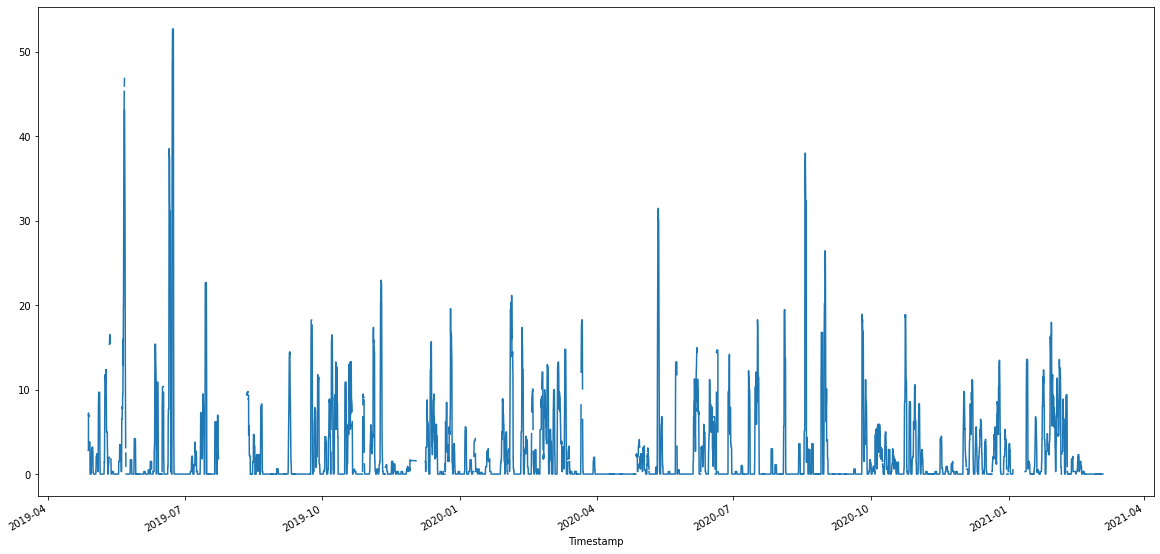

In [11]:
plt.figure(figsize=(20,10))
df["Rain quantity 24h [Liter]"] .plot()
#df["Rain quantity total [Liter]"].plot()

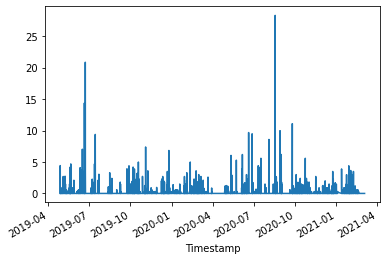

In [12]:
df['Rain quantity 1h [Liter]']=df['Rain quantity 24h [Liter]'].diff()
df['Rain quantity 1h [Liter]']=df['Rain quantity 1h [Liter]'].clip(0,100)
df['Rain quantity 1h [Liter]']=df['Rain quantity 1h [Liter]'].replace(100,np.nan).interpolate()
df['Rain quantity 1h [Liter]'].plot()


In [13]:
#Korrigierte Daten abspeichern als xls
df.to_excel('../log/data_collection.xlsx')

### Datensatz zerlegen 
1. Grunddaten Pegel, Menge, Nachspeisung, Regen

In [14]:
# 1. Grunddaten
dfg=df.iloc[:,0:9]
dfg.tail(30)

,Log File,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter]
Timestamp,,,,,,,,,
2021-03-03 10:50:32,210304155450_V423.csv,2021-03-03 10:50:32,920,2890,98,Kein Fehler erkannt,1.44,10840,0.0
2021-03-03 11:50:41,210304155450_V423.csv,2021-03-03 11:50:41,919,2887,98,Kein Fehler erkannt,1.47,10840,0.0
2021-03-03 12:50:50,210304155450_V423.csv,2021-03-03 12:50:50,904,2840,100,Kein Fehler erkannt,0.00,10840,0.0
2021-03-03 13:50:57,210304155450_V423.csv,2021-03-03 13:50:57,901,2830,98,Kein Fehler erkannt,1.02,10840,0.0
2021-03-03 14:51:06,210304155450_V423.csv,2021-03-03 14:51:06,899,2824,98,Kein Fehler erkannt,1.49,10840,NaN
2021-03-03 15:51:13,210304155450_V423.csv,2021-03-03 15:51:13,899,2824,100,Kein Fehler erkannt,0.00,10840,0.0
2021-03-03 16:51:22,210304155450_V423.csv,2021-03-03 16:51:22,796,2500,100,Kein Fehler erkannt,0.00,10840,0.0
2021-03-03 17:51:30,210304155450_V423.csv,2021-03-03 17:51:30,792,2488,100,Kein Fehler erkannt,0.00,10840,0.0
2021-03-03 18:51:38,210304155450_V423.csv,2021-03-03 18:51:38,790,2481,100,Kein Fehler erkannt,0.00,10840,0.0


2. Filter-Diagnosedaten

In [15]:
# 2. Filter-Diagnosedaten
# Werte auswaehlen
dfd=df.iloc[:, 1:14]
dfd['Rain quantity 1h [Liter]']=df['Rain quantity 1h [Liter]']
dfd_failed=dfd.where(dfd['Filter diagnosis [-]']==0).dropna(axis=0,how='all')
dfd_ok = dfd.where(dfd['Filter diagnosis [-]']==1).dropna(axis=0,how='all')
dfd_all=pd.concat([dfd_failed, dfd_ok])
dfd_all.sort_values('Timestamp')
dfd_all.tail(20)

,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 1h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Rain quantity 1h [Liter]
Timestamp,,,,,,,,,,,,,,
2020-10-23 17:32:22,2020-10-23 17:32:22,791.0,2485.0,94.0,Kein Fehler erkannt,4.81,10740.0,12.670670,0.0,205.0,149.0,0.0,1.0,1.695947
2020-10-23 18:32:30,2020-10-23 18:32:30,953.0,2993.0,94.0,Kein Fehler erkannt,5.75,10740.0,18.257948,0.0,508.0,539.0,5.0,1.0,5.587278
2020-10-26 07:41:06,2020-10-26 07:41:06,1043.0,3276.0,98.0,Kein Fehler erkannt,1.41,10740.0,2.993072,0.0,223.0,220.0,0.0,1.0,2.394450
2020-10-26 08:41:14,2020-10-26 08:41:14,1116.0,3506.0,93.0,Kein Fehler erkannt,6.37,10740.0,4.988453,0.0,230.0,180.0,0.0,1.0,1.995381
2020-10-26 09:41:22,2020-10-26 09:41:22,1157.0,3634.0,98.0,Kein Fehler erkannt,1.54,10740.0,6.185753,0.0,128.0,100.0,0.0,1.0,1.197300
2020-10-26 10:41:31,2020-10-26 10:41:31,1195.0,3754.0,96.0,Kein Fehler erkannt,3.62,10740.0,7.382910,0.0,120.0,99.0,0.0,1.0,1.197157
2020-10-29 05:50:48,2020-10-29 05:50:48,1287.0,4043.0,93.0,Kein Fehler erkannt,6.18,10740.0,4.689145,0.0,223.0,159.0,0.0,1.0,1.795843
2020-10-29 07:51:05,2020-10-29 07:51:05,1357.0,4263.0,100.0,Kein Fehler erkannt,0.00,10740.0,5.886374,0.0,208.0,180.0,0.0,1.0,1.696026
2020-10-29 20:52:52,2020-10-29 20:52:52,1391.0,4369.0,98.0,Kein Fehler erkannt,1.49,10740.0,6.784374,0.0,113.0,99.0,0.0,1.0,1.197371


3. Verbrauchsberechnung

In [16]:
# 3. Verbrauchsdaten
dfv=df.iloc[:,14:16]

#Werte kleiner Null abschneiden (SW-Fehler)
dfv['Usage in last 24h [Liter]']=dfv['Usage in last 24h [Liter]'].clip(lower=0)
dfv['Usage average in last 10d [Liter]']=dfv['Usage average in last 10d [Liter]'].clip(lower=0)
dfv=dfv.where(dfv['Usage in last 24h [Liter]']>0)
# NaNs entfernen
dfv=dfv.dropna(axis=0,how='any')
dfv.tail()

,Usage in last 24h [Liter],Usage average in last 10d [Liter]
Timestamp,,
2019-12-03 01:38:34,158.0,258.0
2019-12-04 01:41:53,65.0,240.0
2019-12-05 01:45:12,38.0,208.0
2019-12-06 01:48:30,71.0,180.0
2019-12-07 01:51:50,201.0,180.0


### Pegeldaten analysieren

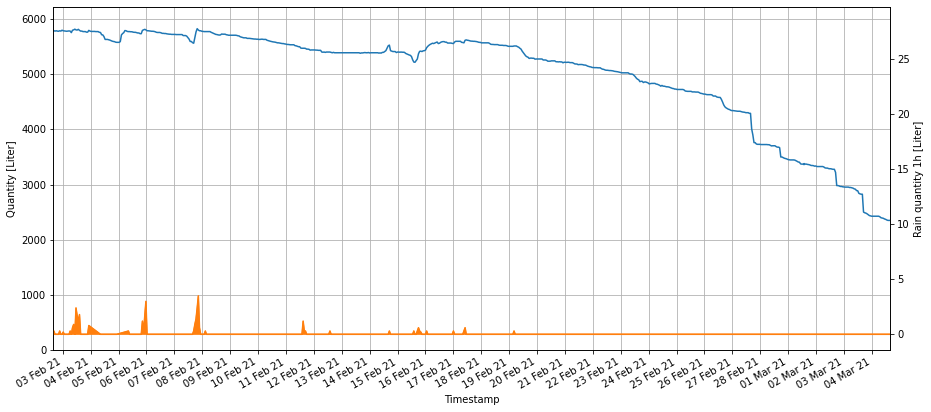

In [17]:
#plot data
fig, ax = plt.subplots(figsize=(15,7))
df['Quantity [Liter]'].plot(ax=ax,grid=True)
df['Rain quantity 1h [Liter]'].plot(ax=ax,grid=True,secondary_y=True,kind='area')
df['Filter diagnosis [-]'].where(df['Filter diagnosis [-]']==0).plot(ax=ax,grid=True,secondary_y=True,marker='o',color ='r')
(df['Filter diagnosis [-]']-1).where(df['Filter diagnosis [-]']==1).plot(ax=ax,grid=True,secondary_y=True,marker='o',color ='g')

#set ticks every month
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.set_xlim(max(df['Timestamp']) - datetime.timedelta(days=30),max(df['Timestamp']))
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %y'))
ax.set_ylabel('Quantity [Liter]')
plt.ylabel('Rain quantity 1h [Liter]');


### Filter-Diagnose analysieren

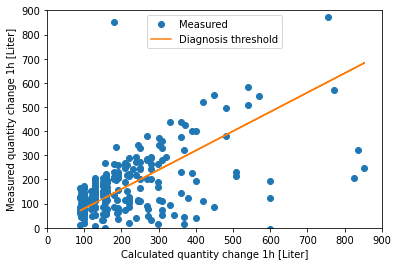

In [18]:
plt.plot(dfd_all['Calculated quantity change 1h [Liter]'],dfd_all['Measured quantity change 1h [Liter]'],'o')
plt.plot(dfd_all['Calculated quantity change 1h [Liter]'],0.8*dfd_all['Calculated quantity change 1h [Liter]'])
plt.xlabel('Calculated quantity change 1h [Liter]')
plt.ylabel('Measured quantity change 1h [Liter]')
plt.xlim([0, 900])
plt.ylim([0, 900])
plt.legend({'Measured','Diagnosis threshold'});

### Fehlerhafte Datenpunkte
Filterverstopfung angezeigt aber tatsächlich nicht verstopft

In [19]:
numPntsOK = dfd_ok.Date.count()
numPntsFailed = dfd_failed.Date.count()
numPntsTot=numPntsFailed+numPntsOK
print("Korrekt erkannte OK-Fälle   : ", numPntsOK, " (", 100*numPntsOK/numPntsTot, "%)")
print("Fehlerhaft erkannte OK-Fälle: ", numPntsFailed, " (", 100*numPntsFailed/numPntsTot, "%)")


Korrekt erkannte OK-Fälle   :  184  ( 64.56140350877193 %)
Fehlerhaft erkannte OK-Fälle:  101  ( 35.43859649122807 %)


In [20]:
dfd_failed.tail(20)
#Manuelle Analyse: 
#2018-12-22 20:44:12 Speicher voll aber Diagnose noch aktiv --> behoben in SW durch größeres Band 
#2018-12-22 06:03:12 Speicher voll aber Diagnose noch aktiv --> behoben in SW durch größeres Band 
#2018-12-21 08:00:18 Speicher voll aber Diagnose noch aktiv --> behoben in SW durch größeres Band 
#2018-12-02 19:14:00 geringe Überschreitung
#2018-12-02 21:14:00 geringe Überschreitung, Starkregen
#2018-12-03 17:17:00 geringe Überschreitung
#2018-12-03 21:18:06 Starkregen
#2019-02-10 17:03:22 Starkregen

,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 1h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Rain quantity 1h [Liter]
Timestamp,,,,,,,,,,,,,,
2020-06-04 13:07:20,2020-06-04 13:07:20,279.0,876.0,100.0,Kein Fehler erkannt,0.00,8340.0,6.784296,0.0,47.0,120.0,60.0,0.0,1.396767
2020-06-04 19:08:09,2020-06-04 19:08:09,269.0,845.0,98.0,Kein Fehler erkannt,1.54,8340.0,7.981524,0.0,70.0,99.0,29.0,0.0,1.197229
2020-06-05 02:09:01,2020-06-05 02:09:01,337.0,1058.0,100.0,Kein Fehler erkannt,0.00,8340.0,10.975483,0.0,63.0,99.0,36.0,0.0,1.198116
2020-06-05 22:11:55,2020-06-05 22:11:55,339.0,1065.0,98.0,Kein Fehler erkannt,1.02,8340.0,9.677598,0.0,192.0,600.0,68.0,0.0,6.185681
2020-06-07 03:08:24,2020-06-07 03:08:24,522.0,1639.0,98.0,Kein Fehler erkannt,1.52,8340.0,8.625257,0.0,62.0,100.0,38.0,0.0,1.203610
2020-06-11 07:00:53,2020-06-11 07:00:53,655.0,2057.0,98.0,Kein Fehler erkannt,1.26,8340.0,4.988453,0.0,56.0,150.0,62.0,0.0,1.696112
2020-06-16 03:17:02,2020-06-16 03:17:02,976.0,3066.0,100.0,Kein Fehler erkannt,0.00,8340.0,5.287760,0.0,79.0,270.0,70.0,0.0,0.299365
2020-06-19 19:27:42,2020-06-19 19:27:42,1198.0,3763.0,90.0,Kein Fehler erkannt,8.62,8340.0,9.676928,0.0,248.0,853.0,70.0,0.0,9.676928
2020-06-27 13:53:21,2020-06-27 13:53:21,765.0,2403.0,98.0,Kein Fehler erkannt,1.15,8340.0,9.477841,0.0,324.0,835.0,61.0,0.0,9.477841


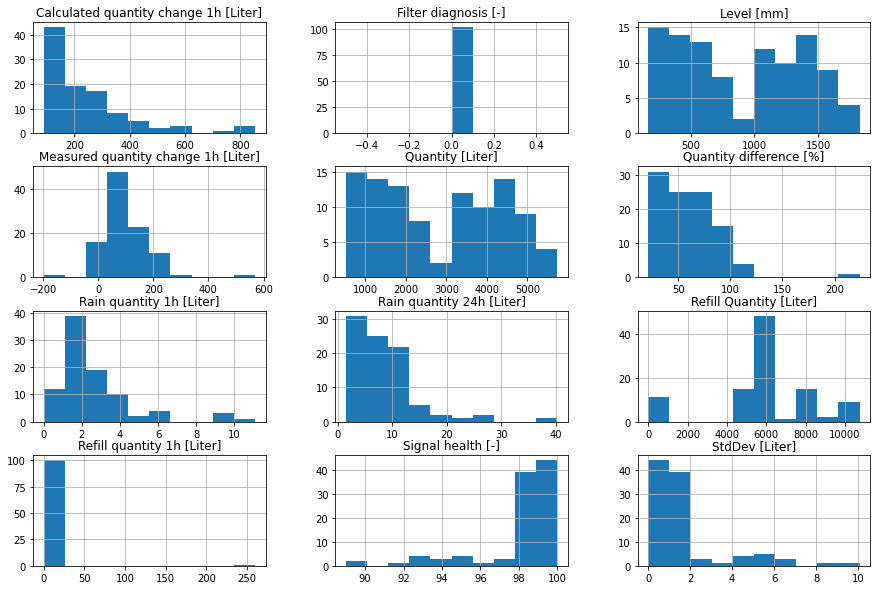

In [21]:
dfd_failed.hist(figsize=[15, 10]);

In [22]:
#dfd_ok.tail()

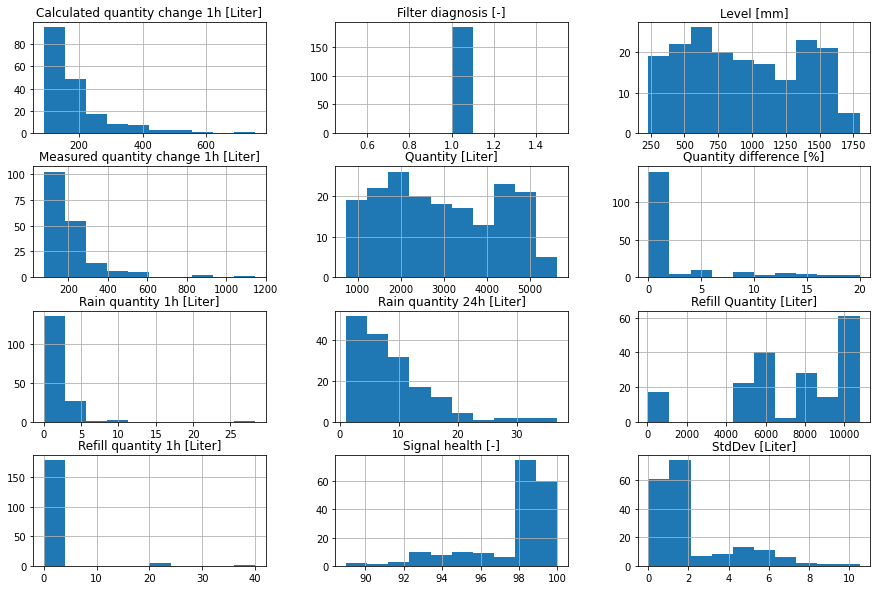

In [23]:
dfd_ok.hist(figsize=[15, 10]);

### Aufsummierte Regenmenge

### Filtereffizienz

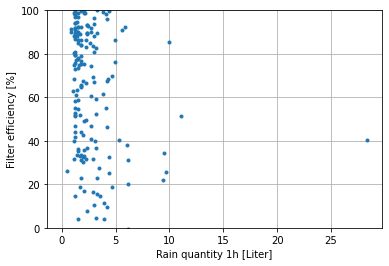

In [24]:
aRoof = 100
dfd["rEffFlt [%]"] = 100*(dfd["Measured quantity change 1h [Liter]"]/(dfd["Rain quantity 1h [Liter]"]*aRoof))
plt.plot(dfd["Rain quantity 1h [Liter]"],dfd["rEffFlt [%]"],'.');
plt.xlabel('Rain quantity 1h [Liter]')
plt.ylabel('Filter efficiency [%]')
plt.ylim([0, 100])
plt.grid()

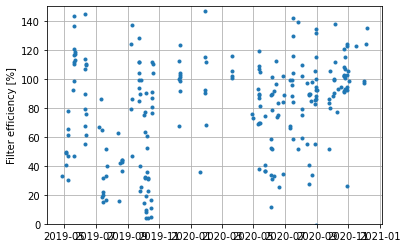

In [25]:
plt.plot(dfd["rEffFlt [%]"],'.');

plt.ylabel('Filter efficiency [%]')
plt.ylim([0,150])
plt.grid()

In [26]:
dfd_all=dfd.dropna(axis=0,how='any')
dfd_all.tail(20)

,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 1h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Rain quantity 1h [Liter],rEffFlt [%]
Timestamp,,,,,,,,,,,,,,,
2020-10-23 18:32:30,2020-10-23 18:32:30,953,2993,94,Kein Fehler erkannt,5.75,10740,18.257948,0.0,508.0,539.0,5.0,1.0,5.587278,90.920842
2020-10-26 07:41:06,2020-10-26 07:41:06,1043,3276,98,Kein Fehler erkannt,1.41,10740,2.993072,0.0,223.0,220.0,0.0,1.0,2.394450,93.132020
2020-10-26 08:41:14,2020-10-26 08:41:14,1116,3506,93,Kein Fehler erkannt,6.37,10740,4.988453,0.0,230.0,180.0,0.0,1.0,1.995381,115.266204
2020-10-26 09:41:22,2020-10-26 09:41:22,1157,3634,98,Kein Fehler erkannt,1.54,10740,6.185753,0.0,128.0,100.0,0.0,1.0,1.197300,106.907202
2020-10-26 10:41:31,2020-10-26 10:41:31,1195,3754,96,Kein Fehler erkannt,3.62,10740,7.382910,0.0,120.0,99.0,0.0,1.0,1.197157,100.237462
2020-10-29 05:50:48,2020-10-29 05:50:48,1287,4043,93,Kein Fehler erkannt,6.18,10740,4.689145,0.0,223.0,159.0,0.0,1.0,1.795843,124.175669
2020-10-29 07:51:05,2020-10-29 07:51:05,1357,4263,100,Kein Fehler erkannt,0.00,10740,5.886374,0.0,208.0,180.0,0.0,1.0,1.696026,122.639664
2020-10-29 20:52:52,2020-10-29 20:52:52,1391,4369,98,Kein Fehler erkannt,1.49,10740,6.784374,0.0,113.0,99.0,0.0,1.0,1.197371,94.373384
2020-10-29 21:53:01,2020-10-29 21:53:01,1430,4492,96,Kein Fehler erkannt,3.70,10740,7.981616,0.0,123.0,100.0,0.0,1.0,1.197242,102.736082


In [27]:
dfd["rEffFlt [%]"].plot(kind='hist')

ValueError: autodetected range of [-110.25208333333264, inf] is not finite

### Verbrauchsberechnung

In [ ]:
dfv.tail(10)

In [ ]:
dfv.describe()

In [ ]:
dfv.hist();

In [ ]:
#plot data
fig, ax = plt.subplots(figsize=(15,7))
dfv.plot(ax=ax,grid=True,style='.-')

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
